In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Edits (major):

# changed params file to boxsize 120 arcmin, dx = 4 for 2 degree patch, otherwise noise cov and pinv are taking 
# up too much space
# covariance matrix definition changed to the one below

In [3]:
import numpy as np, sys, os, scipy as sc, healpy as H, warnings, pickle, gzip
sys_folder = '../modules/'
sys.path.append(sys_folder)

import flatsky, tools, misc, moving_lens, inpaint, foregrounds as fg

import scipy.ndimage as ndimage
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_defs
cosmology.setCosmology('planck15')
from astropy.cosmology import FlatLambdaCDM

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu_r

In [4]:
#others
perform_inpainting = False #True
use_pol_for_inpainting = False
mask = None
perform_oned_fitting = 1   

In [5]:
# read params file, if we need it

# params or supply a params file
paramfile = 'params_bullter_cluster.ini'

param_dict = misc.fn_get_param_dict(paramfile)

if not perform_oned_fitting:
    param_dict['boxsize'], param_dict['dx'] = 120., 2.

boxsize, dx = param_dict['boxsize'], param_dict['dx']
boxsize_am = boxsize
dls_file = param_dict['dls_file']
lmax, nside =  param_dict['lmax'],  param_dict['nside']
mask_file = param_dict['mask_file']

In [6]:
#get ra, dec or map-pixel grid
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [7]:
#read Cls now
if (0):#not use_pol_for_inpainting:
    el, dl = np.loadtxt(dls_file, usecols = [0,1], unpack = 1)
else:
    el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(dls_file, unpack = 1)
    dl_all = np.asarray([dl_tt, dl_ee, dl_bb, dl_te])

dl_fac = el * (el + 1) / 2 / np.pi
cl_all = dl_all / dl_fac * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all
print(len(el), cl_tt.shape)

27658 (27658,)


In [8]:
# Set up beam

beamval = 1.2 #arcmins
bl2d = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)

In [9]:
# Set up noise

noiseval = 2.0 #uK-arcmin
noofsims_for_cov = 1000 #1500

nl = tools.get_nl(noiseval, el)

In [10]:
# Set up sims for noise covariance matrix

noise_sims = list()

for i in tqdm(range(noofsims_for_cov)):
    noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl)
    noise_sims.append(noise_map)
    
npix = nx ** 2
noise_sims = np.asarray(noise_sims).flatten().reshape(noofsims_for_cov, npix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3455.57it/s]


In [11]:
# ask -- the calcCov function in this version of tools uses sample covariance not population covariance??
# also using calcCov takes up too much memory space (26GB +) for such a numpy matrix. I used direct matmul instead.
# verify that this is a viable alternative; still a very big matrix.

noise_cov = np.matmul(noise_sims.T , noise_sims) / (noofsims_for_cov)
noise_cov.shape

(900, 900)

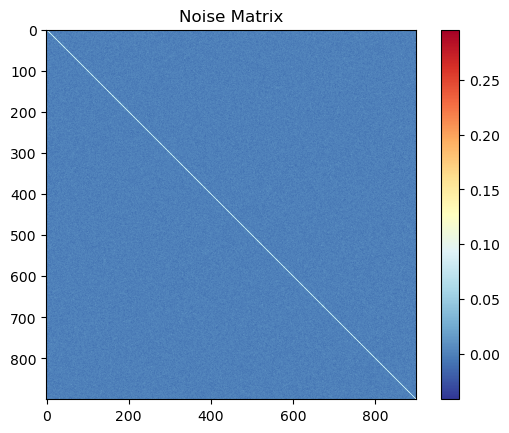

In [12]:
plt.imshow(noise_cov, cmap = cmap); colorbar(); title("Noise Matrix"); show()

---------------

In [14]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [15]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 0.00021610260009765624
check me. 
		time taken for get dot product = 6.635983784993489e-07
(1, 30, 30) (1,) (1,)
1
(1, 30, 30) (1,) (1,)


/home/dchanda2002/MovingLensBC/transverse_velocity/scripts/../modules/moving_lens.py:623: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec_tmp = np.asarray( [phi, theta, 0.] )


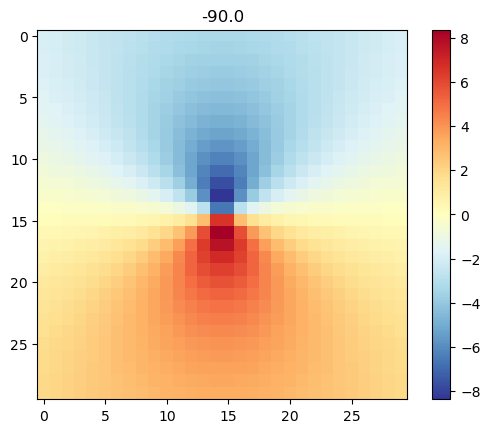

In [16]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

-----------------

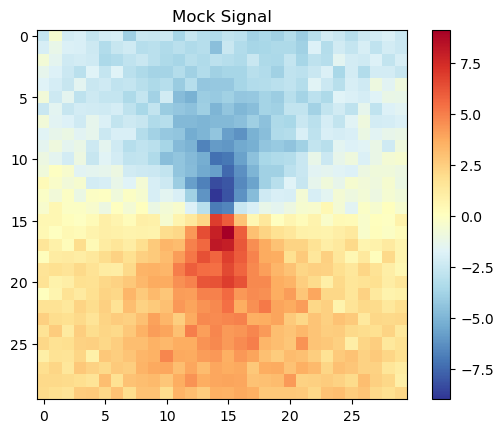

In [17]:
# Make a mock

ml_signal = mvl_arr[0]
noise_signal = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = ml_signal + noise_signal
plt.imshow(mock_signal, cmap = cmap); colorbar(); title("Mock Signal"); show()

In [18]:
# Attempt a simple Emcee with amplitude of ML signal(even though there's just one param here :/ but at least it samples the
# distribution)

# To save shallow copy space, use global memory for now

cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(amplitude):
    # cov_inv = np.ones_like(noise_cov)  # for testing

    d = data.flatten() ## - np.mean(MAP.flatten())
    m = amplitude * ml_signal.flatten() ## - np.mean(MODEL.flatten())
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amplitude):
    if (amplitude < 5) & (amplitude > -5):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(amplitude):
    prior = log_prior(amplitude)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(amplitude)


In [19]:
sample_amp = np.arange(-5,5,0.1)
likelihood = [log_likelihood(amp) for amp in tqdm(sample_amp)]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10283.18it/s]


In [20]:
like = likelihood - max(likelihood)
like = np.exp(like)
like/=max(like)
amp_mode=sample_amp[np.argmax(like)]

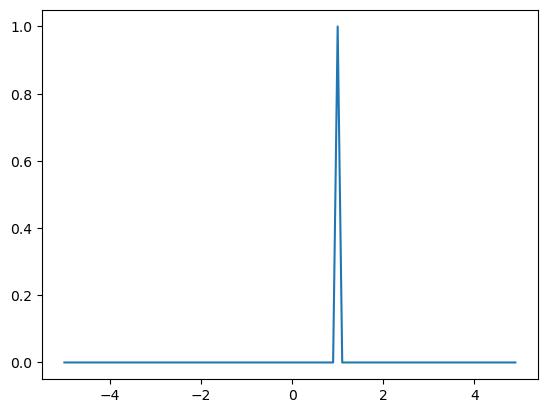

In [21]:
plt.plot(sample_amp, like)

In [22]:
# Then try using emcee

from multiprocessing import Pool

initial = np.random.rand(32, 1) + 0.5  # centered around an amplitude of 1
nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 1000, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

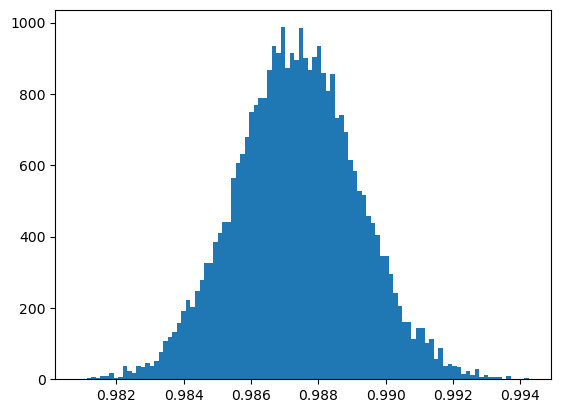

In [23]:
plt.hist(samples, bins = 100)
plt.show()

In [24]:
sixteen = np.percentile(samples, 16.)
eightyfour = np.percentile(samples, 84.)
mean = np.percentile(samples, 50.) # not really mean; change later
lowerr = mean - sixteen
higherr = eightyfour - mean

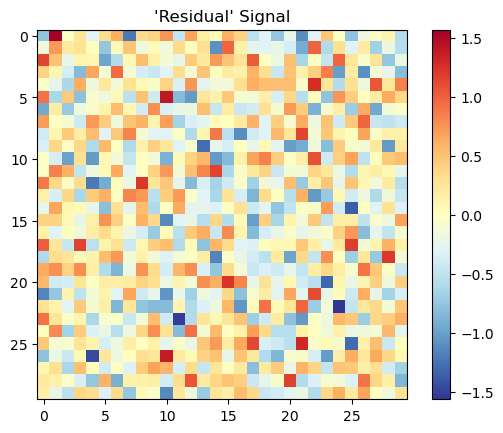

In [25]:
plt.imshow(mock_signal - amp_mode*ml_signal, cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

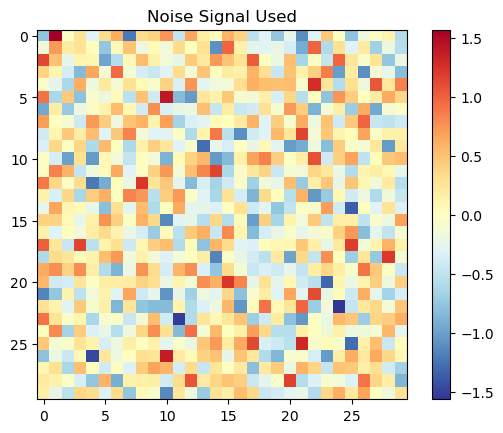

In [26]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

---------------

In [36]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(theta):
    
    velocity, mass = theta
    d = data.flatten() ## - np.mean(MAP.flatten())
    
    v_phi = [v_phi_1]
    phi = [phi_1]
    theta = [theta_1]
    redshift = [redshift_1]
    
    M200c = [mass]
    v_th = [velocity]
    
    noofclus = len(M200c)
    ra_list = dec_list = np.zeros(len(M200c))
    
    mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, 
                                                    dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, 
                                                    param_dict, bl = bl2d)
    m = mvl_arr[0].flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(theta):
    velocity, mass = theta
    if (velocity < 6000) & (velocity > 3000) & (mass < 1.5e16) & (mass > 1.5e14):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(theta):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [37]:
v_init = (np.random.rand(32, 1) - 0.5) *500 + 4500
m_init = (np.random.rand(32, 1) - 0.5) *5e14 + 1.5e15
initial = np.hstack([v_init, m_init])

In [ ]:
# Try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = True)
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 300, progress = True)
    samples = sampler.get_chain(flat = True)

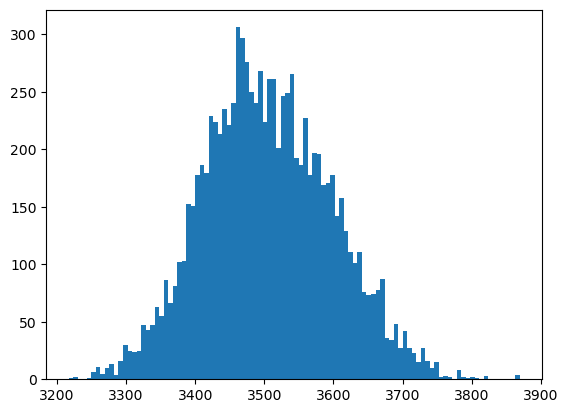

In [47]:
vel_flat = samples[:,0]
mass_flat = samples[:,1]

v_arr, v_bins, foo1 = plt.hist(vel_flat, bins = 100)
plt.show()

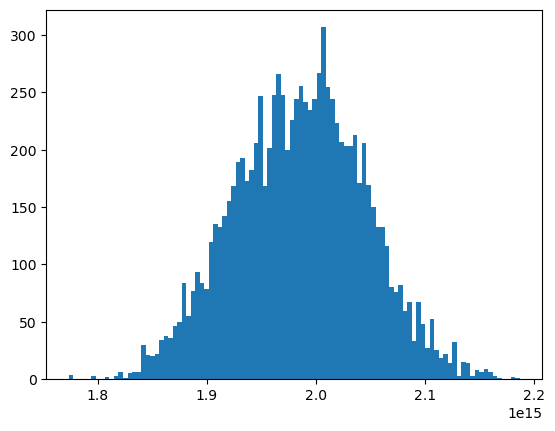

In [48]:
M_arr, M_bins, foo2 = plt.hist(mass_flat, bins = 100)
plt.show()

In [49]:
v_mode=v_bins[np.argmax(v_arr)]
M_mode=M_bins[np.argmax(M_arr)]

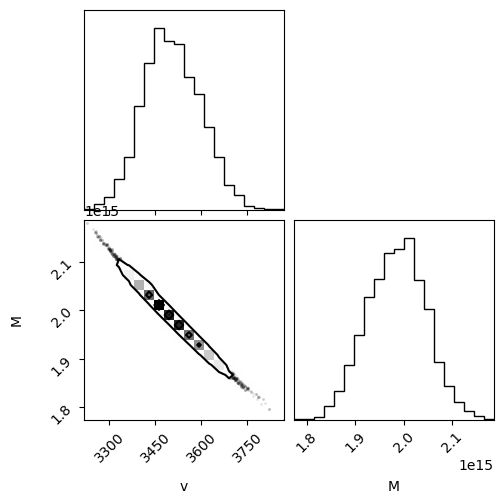

In [52]:
import corner 

labels = ["v", "M"]

fig = corner.corner(
    samples, labels = labels, truths = [4500, 1.5e15]
)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=20.050, z=0.30
		time taken for gettting deflection vector = 4.460016886393229e-05
check me. 
		time taken for get dot product = 4.172325134277344e-07


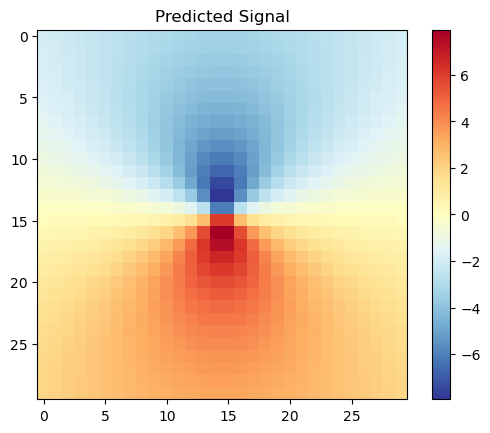

In [53]:
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [M_mode], redshift, v_phi, [v_mode], param_dict, bl = bl2d)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Predicted Signal")

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=20.000, z=0.30
		time taken for gettting deflection vector = 3.5985310872395834e-05
check me. 
		time taken for get dot product = 4.76837158203125e-07
get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 2.6977062225341798e-05
check me. 
		time taken for get dot product = 3.6557515462239586e-07


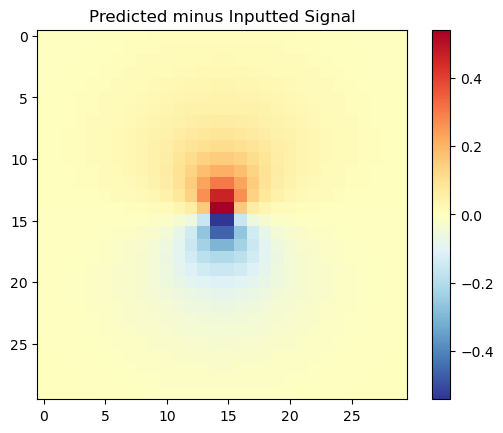

In [28]:
mvl_arr1, vel_dir_arr1, vel_mag_arr1 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [2e15], redshift, v_phi, [3450], param_dict, bl = bl2d)
mvl_arr2, vel_dir_arr2, vel_mag_arr2 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [1.5e15], redshift, v_phi, [4500], param_dict, bl = bl2d)
plt.imshow(mvl_arr1[0] - mvl_arr2[0], cmap = cmap); colorbar(); title("Predicted minus Inputted Signal"); show()

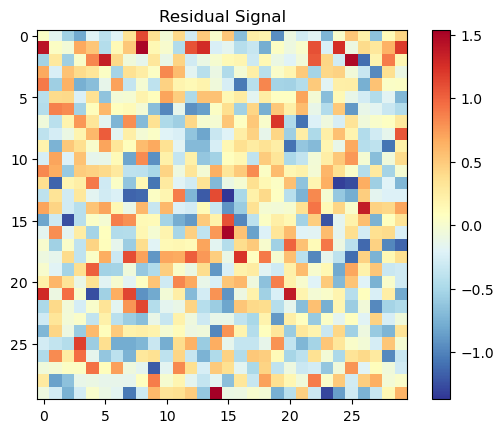

In [54]:
# Despite not being the same mass and velocity values, this mass and velocity gives a surprisingly accurate result.
# Maybe its because ML signal is prop to mass and velocity (so higher mass and lower velocity results in same signal)

plt.imshow(mock_signal - mvl_arr[0], cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

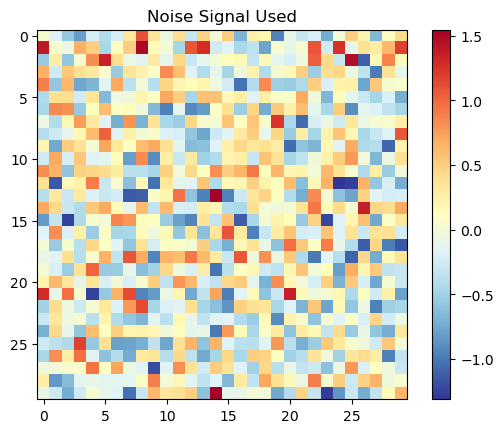

In [55]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

-------------------